In [1]:
import torch
from src.data.dataset import CNSDataset
from torch.utils.data import DataLoader
from src.descriptors import DescriptorGenerator, AVAILABLE_DESCRIPTORS

from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.swa_utils import AveragedModel, SWALR
from sklearn.metrics import fbeta_score

from IPython import display
from rich.progress import track
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.random.manual_seed(0)

In [3]:
from src.data.dataset import CNSDataset
from src.descriptors import DescriptorGenerator, AVAILABLE_DESCRIPTORS

from torch.utils.data import DataLoader, random_split

import numpy as np
TRAIN_DATASET = "dataset\mol_train.csv"
TEST_DATASET = "dataset\mol_test.csv"

whole_dataset = CNSDataset(TRAIN_DATASET, transform=DescriptorGenerator(AVAILABLE_DESCRIPTORS))
mean = torch.mean(whole_dataset._processed_data, axis=0)
std = torch.std(whole_dataset._processed_data, axis=0)
whole_dataset.standardize(mean, std)

nfeatures = whole_dataset._processed_data.shape[1]

print(f"Now the shape is {whole_dataset._processed_data.shape}")

Output()

NaN in descriptors, remove it
Now the shape is torch.Size([700, 126])


In [4]:
train, validation = random_split(
    whole_dataset,
    [0.9, 0.1],
)
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size)
validation_loader = DataLoader(validation, batch_size=len(validation))

In [5]:
model = nn.Sequential(
    nn.Linear(nfeatures, 512),
    nn.LayerNorm(512),
    nn.SiLU(),
    nn.Dropout(0.6),
    nn.Linear(512, 512),
    nn.LayerNorm(512),
    nn.SiLU(),
    nn.Dropout(0.6),
    nn.Linear(512, 128),
    nn.LayerNorm(128),
    nn.SiLU(),
    nn.Dropout(0.6),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
model.to(device)
loss_fn = nn.BCELoss()
loss_fn.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-1)
scheduler = CosineAnnealingLR(optimizer, 200, eta_min=1e-14)
swa_model = AveragedModel(model)
swa_start = 900
swa_scheduler = SWALR(optimizer, swa_lr=1e-6)

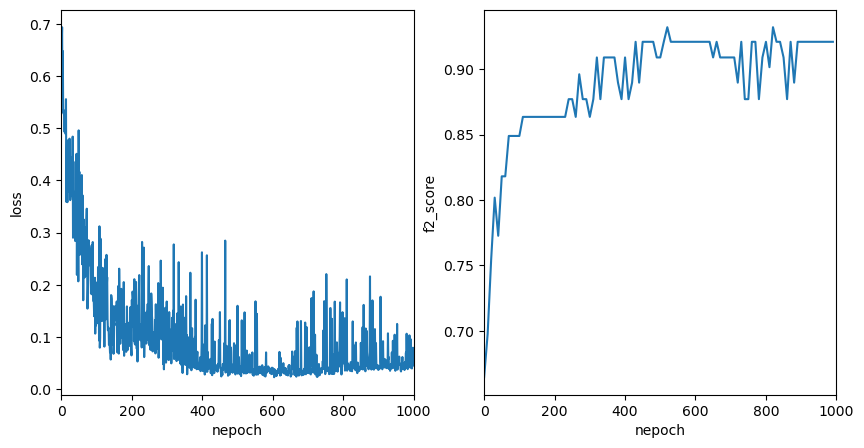

In [6]:
model.train()
train_losses = []
val_x = []
f2s = []


total_epoch = 1000
for nepoch in range(total_epoch):
    for batch in train_loader:
        y_pred = model(batch[0])
        #y_pred[y_pred > 0.5] = 1.
        #y_pred[y_pred <= 0.5] = 0.
        loss = loss_fn(y_pred, batch[1].to(device).reshape(-1, 1).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if nepoch > swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step()
    train_losses.append(loss.cpu().detach().numpy())
    if nepoch % 10 == 0:
        model.eval()
        val_x.append(nepoch)
        for batch in validation_loader:
            y_pred = model(batch[0])
            y_pred[y_pred > 0.5] = 1.
            y_pred[y_pred <= 0.5] = 0.
            f2s.append(fbeta_score(y_pred.detach().cpu().numpy(), batch[1], beta=2))
        model.train()
    %matplotlib inline
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(train_losses)
    ax[0].set_xlim((0, total_epoch))
    ax[0].set_xlabel("nepoch")
    ax[0].set_ylabel("loss")
    ax[1].set_xlim((0, total_epoch))
    ax[1].set_xlabel("nepoch")
    ax[1].set_ylabel("f2_score")
    ax[1].plot(val_x, f2s)

    plt.show()
    display.clear_output(wait=True)

torch.optim.swa_utils.update_bn(train_loader, swa_model)

In [8]:
model.eval()
for batch in validation_loader:
    y_pred = model(batch[0])
    y_pred[y_pred > 0.5] = 1.
    y_pred[y_pred <= 0.5] = 0.
    print(fbeta_score(y_pred.cpu().detach().numpy(), batch[1], beta=2))

0.9210526315789475


In [9]:
test = CNSDataset(TEST_DATASET, transform=DescriptorGenerator(AVAILABLE_DESCRIPTORS))
test.standardize(mean, std)

Output()

NaN in descriptors, remove it


In [10]:
model.eval()
result = model(test._processed_data).cpu().detach().numpy()

In [11]:
result[result < 0.5] = 0
result[result >= 0.5] = 1

In [12]:
result = result.astype(int)

In [13]:
result.reshape(-1)

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,

In [4]:
from rdkit.Chem.rdMolDescriptors import CalcGETAWAY
from rdkit import Chem
from rdkit.Chem import AllChem

In [5]:
mol = Chem.MolFromSmiles('CC[N+](C)(CC)CCOC(=O)C1c2ccccc2Oc3ccccc13')
molH = Chem.AddHs(mol)
AllChem.EmbedMolecule(molH)

0

In [6]:
Chem.rdmolops.GetFormalCharge(molH)

1

In [90]:
a = CalcGETAWAY(molH)

In [91]:
len(a)

273

In [62]:
len(a.ToBinary())

912

In [8]:
charges = []
for s in whole_dataset.raw_data['SMILES']:
    print(s)
    mol = Chem.MolFromSmiles(s)
    molH = Chem.AddHs(mol)
    AllChem.EmbedMolecule(molH)
    charge = Chem.rdmolops.GetFormalCharge(molH)
    charges.append(charge)

CC1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)CC(=O)CC(O)C(C(O)CC(OC2OC(C)C(O)C(N)C2O)C=CC=CC=CC=CCCC=CC=CC(C)C(O)C1C)C(=O)O
NCCCCC(NC(CCc1ccccc1)C(=O)O)C(=O)N2CCCC2C(=O)O
c1ccc(cc1)C2=NCC(=O)Nc3c2cc(cc3)[N+](=O)[O]
CCN(CC)C(C)CN1c2ccccc2Sc3c1cccc3
CC(CCCC(C)(C)O)C1CCC2C(=CC=C3CC(O)CC(O)C3=C)CCCC12C
c1ccc(cc1)C(c2ccc(cc2)Cl)N3CCN(CC3)CCOCCO
CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1
NC12CC3CC(CC(C3)C1)C2
CC1CCc2cc(F)cc3C(=O)C(=CN1c23)C(=O)O
CC1OC(CC(OC(=O)C)C1O)OC2C(O)CC(OC3C(O)CC(OC4CCC5(C)C(CCC6C5CCC7(C)C(CCC67O)C8=CC(=O)OC8)C4)OC3C)OC2C
CCc1cc2c(s1)n3c(nnc3CN=C2c4ccccc4Cl)C
CC(C)C(N)C(=O)OCC(CO)OCn1cnc2C(=O)NC(=Nc12)N
CC1=C(N2C(C(C2=O)NC(=O)C(=NOC)C3=CSC(=N3)N)SC1)C(=O)OCOC(=O)C(C)(C)C
Cc1onc(c1C(=O)NC2C3SC(C)(C)C(N3C2=O)C(=O)O)c4c(Cl)cccc4Cl
CSC1=CC2=C(SC3=CC=CC=C3N2CCC2CCCCN2C)C=C1
COC(=O)C1C(O)CC2(O)CC(O)CC(O)CC(O)CC(O)CC(=O)CC(O)CC(=O)OC(C(C)CCC(O)CC(=O)c3ccc(N)cc3)C(C)C=CC=CC=CC=CC=CC=CC=CC(CC1O2)OC4OC(C)C(O)C(N)C4O
CON=C(C(=O)NC1C2SCC(=C(N2C1=O)C(=O)O)C)c3csc(N)n3
CC(=O)Nc1ccc(cc1)O
CC(Cc1ccc2OCOc2c1

In [13]:
mol.GetFormalCharge()

AttributeError: 'Mol' object has no attribute 'GetFormalCharge'

In [12]:
whole_dataset[np.array(charges) != 0]

(tensor([[-0.4073, -0.4804, -0.7338,  ...,  1.2186, -0.5176, -0.5633],
         [ 0.1986, -0.0869, -0.4575,  ...,  0.3002, -0.5176, -0.5633],
         [-0.0396, -0.4570, -0.5475,  ...,  2.4272, -0.5176, -0.5633],
         ...,
         [-0.4220, -0.2439,  0.2537,  ...,  1.2186, -0.5176, -0.5633],
         [ 0.2673, -0.0869,  1.0697,  ..., -0.6182, -0.5176,  1.0381],
         [-0.2146,  0.0883,  0.4699,  ..., -0.6182, -0.5176, -0.5633]],
        device='cuda:0'),
 2      1
 21     0
 32     0
 51     0
 53     0
 56     0
 59     0
 150    0
 167    0
 184    0
 190    0
 225    0
 246    0
 248    0
 254    0
 270    1
 272    0
 287    0
 343    0
 385    0
 386    0
 396    0
 432    1
 442    0
 445    1
 465    1
 472    0
 495    0
 504    0
 509    0
 512    0
 522    0
 531    0
 533    0
 555    1
 562    0
 573    0
 575    0
 579    0
 585    1
 616    0
 629    0
 657    0
 677    0
 681    0
 Name: TARGET, dtype: int64)

In [32]:
[int(item) for item in list(a.ToBinary())]

[1,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 128,
 0,
 112,
 0,
 0,
 0,
 129,
 4,
 9,
 0,
 15,
 0,
 0,
 0,
 130,
 4,
 9,
 0,
 23,
 0,
 0,
 0,
 131,
 4,
 9,
 0,
 25,
 0,
 0,
 0,
 132,
 4,
 9,
 0,
 21,
 0,
 0,
 0,
 133,
 4,
 9,
 0,
 15,
 0,
 0,
 0,
 134,
 4,
 9,
 0,
 13,
 0,
 0,
 0,
 135,
 4,
 9,
 0,
 4,
 0,
 0,
 0,
 136,
 4,
 9,
 0,
 3,
 0,
 0,
 0,
 137,
 4,
 9,
 0,
 1,
 0,
 0,
 0,
 129,
 196,
 10,
 0,
 6,
 0,
 0,
 0,
 130,
 196,
 10,
 0,
 14,
 0,
 0,
 0,
 131,
 196,
 10,
 0,
 20,
 0,
 0,
 0,
 132,
 196,
 10,
 0,
 19,
 0,
 0,
 0,
 133,
 196,
 10,
 0,
 12,
 0,
 0,
 0,
 134,
 196,
 10,
 0,
 9,
 0,
 0,
 0,
 135,
 196,
 10,
 0,
 9,
 0,
 0,
 0,
 136,
 196,
 10,
 0,
 5,
 0,
 0,
 0,
 137,
 196,
 10,
 0,
 1,
 0,
 0,
 0,
 138,
 196,
 10,
 0,
 1,
 0,
 0,
 0,
 97,
 197,
 10,
 0,
 4,
 0,
 0,
 0,
 98,
 197,
 10,
 0,
 3,
 0,
 0,
 0,
 99,
 197,
 10,
 0,
 2,
 0,
 0,
 0,
 100,
 197,
 10,
 0,
 1,
 0,
 0,
 0,
 101,
 197,
 10,
 0,
 1,
 0,
 0,
 0,
 102,
 197,
 10,
 0,
 1,
 0,
 0,
 0,
 103,
 197,
 10,
 0,
 1,
 0

In [35]:
len([int(item) for item in list(a.ToBinary())])

684